In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import scipy
import requests
from matplotlib.patches import Rectangle
from datetime import datetime
# sns.set()

# Introduction <a id='intro'></a>

This notebook cleans and wrangles numerous data sets, making them uniform
so that they can be used in a data-driven model for COVID-19 prediction.

The key cleaning measures are those which find the most viable set of countries and date ranges
such that the maximal amount of data can be used. In other words, different datasets can have data
on a different set of countries; to avoid introducing large quantities of missing values
the intersection of these countries is taken.

# Table of contents<a id='toc'></a>

## [Data wrangling function definitions](#generalfunctions)

# Data <a id='data'></a>
data sources

To get the JHU CSSE data: git clone https://www.github.com/CSSEGISandData/COVID-19

To get the OWID data: git clone https://www.github.com/owid/covid-19-data/

To get and store OxCGRT government response data: git clone https://github.com/OxCGRT/covid-policy-tracker/

To get and store Test Tracker data, go to https://finddx.shinyapps.io/FIND_Cov_19_Tracker/
    
    Choose "Tests and cases" dataset, select "All" as the entry number, 
    save as test_tracker_cases_and_tests.csv in same directory as notebooks.
    
The data in this project goes up to June 30th, 2020
    
    
## [JHU CSSE case data.](#csse)
[https://systems.jhu.edu/research/public-health/ncov/](https://systems.jhu.edu/research/public-health/ncov/)

**Data available at:**
[https://github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

This data is split between a collection of .csv files of two different formats; first, the daily reports (global) are
separated by day, each residing in their own .csv. Additionally, the daily report files have three different formats that need to be taken into account when compiling the data. The daily report data itself contains values on the number of confirmed cases, deceased, active cases, recovered cases.

For the other format, .csv files with 'timeseries' in their filename, the data contains values for confirmed, deceased, recovered and are split between global numbers (contains United States as a whole) and numbers for the united states (statewide).
           
           
## [OWID case and test data](#owid)

**Data available via github**
[https://github.com/owid/covid-19-data](https://github.com/owid/covid-19-data)

[https://ourworldindata.org/covid-testing](https://ourworldindata.org/covid-testing)

The OWID dataset contains information regarding case and test numbers; it overlaps with the JHU CSSE 
and Testing Tracker datasets but I am going to attempt to use it in conjunction with those two because
of how there is unreliable reporting. In other words to get the bigger picture I'm looking to stitch together
multiple datasets.

           
## [OxCGRT government response data](#oxcgrt)

**Data available at:**
[https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv](https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv)


[https://github.com/OxCGRT/covid-policy-tracker/](https://github.com/OxCGRT/covid-policy-tracker/)

The OxCGRT dataset contains information regarding different government responses in regards to social
distancing measures. It measures the type of social distancing measure, whether or not they are recommended
or mandated, whether they are targeted or broad (I think geographically). 
           
## [Testing tracker data](#testtrack)
<!-- **Website which lead me to dataset**
[https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/](https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/) -->

**Data available at:**
[https://finddx.shinyapps.io/FIND_Cov_19_Tracker/](https://finddx.shinyapps.io/FIND_Cov_19_Tracker/)

This dataset contains a time series of testing information: e.g. new (daily) tests, cumulative tests, etc. 


# [Data regularization: making things uniform](#uniformity)

### [Intersection of countries](#country)
  
### [Time series date ranges](#time)

### [Missing Values](#missingval)

## Data wrangling function declaration <a id='generalfunctions'></a>


In [2]:
def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]


def country_search(df, country):
    return df[df.location==country].index


def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]


def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None
    
def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def reformat_values(values_to_transform, category='columns',dateformat=None):
    """ Reformat column and index names. 
    
    Parameters :/
    ----------
    df : Pandas DataFrame
    columns : bool
    index : bool|
    
    Notes :
    -----
    Change headers of columns; this needs to be updated to account for their formatting changes. 
    This function converts strings with CamelCase, underscore and space separators to lowercase words uniformly
    separated with underscores. I.e. (hopefully!) following the correct python identifier syntax so that each column
    can be reference as an attribute if desired. 

    For more on valid Python identifiers, see:
    https://docs.python.org/3/reference/lexical_analysis.html#identifiers
    """
    
    """ Reformat column and index names. only works with with pandas MultiIndex for level=0.
    
    Parameters :
    ----------
    df : Pandas DataFrame

    Notes :
    -----
    Different datasets have different naming conventions (for countries that go by multiple names and abbreviations).
    This function imposes a convention on a selection of these country names.  
    """
    # these lists are one-to-one. countries compared via manual inspection, unfortunately. 
    mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China',
                           'Occupied Palestinian Territory','Republic of Korea', 'Korea, South', 
                           'Gambia, The ', 'UK', 
                           'USA', 'Iran (Islamic Republic of)',
                           'Bahamas, The', 'Russian Federation', 'Czech Republic', 'Republic Of Ireland',
                          'Hong Kong Sar', 'Macao Sar', 'Uk','Us',
                           'Congo ( Kinshasa)','Congo ( Brazzaville)',
                           'Cote D\' Ivoire', 'Viet Nam','Guinea- Bissau','Guinea','Usa']

    mismatch_labels_good = ['Laos','China',
                            'Palestine', 'South Korea', 'South Korea', 
                            'The Gambia', 'United Kingdom', 
                            'United States','Iran',
                            'The Bahamas','Russia','Czechia','Ireland',
                            'Hong Kong','Macao','United Kingdom', 'United States',
                            'Democratic Republic Of The Congo','Republic Of The Congo',
                            'Ivory Coast','Vietnam', 'Guinea Bissau','Guinea Bissau','United States']
    
    # three cases, column names, country names, or datetime. 
    if category == 'location':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append(' '.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                        re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val).lower())
                                                        .split()).title())
        transformed_values = pd.Series(reformatted_values).replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
    
    elif category == 'columns':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append('_'.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                     re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val)
                                                            .lower()).split()))
        transformed_values = pd.Series(reformatted_values)
        
    elif category == 'date':
        transformed_values = pd.to_datetime(pd.Series(
            values_to_transform), errors='coerce',format=dateformat).dt.normalize()


    return transformed_values

#----------------- Helper Functions for regularization ----------------------#
def intersect_country_index(df, country_intersection):
    df_tmp = df.copy().reset_index(level=0)
    df_tmp = df_tmp[df_tmp.location.isin(country_intersection)]
    df_tmp = df_tmp.set_index(['location', df_tmp.index])
    return df_tmp 

def resample_dates(df, dates):
    df = df.loc[~df.index.duplicated(keep='first')]
    return df.reindex(pd.MultiIndex.from_product([df.index.levels[0], dates], names=['location', 'date']), fill_value=np.nan)

def make_multilevel_columns(df):
    df.columns = pd.MultiIndex.from_product([[df.columns.name], df.columns], names=['dataset', 'features'])
    return df

def multiindex_to_table(df):
    df_table = df.copy()
    try:
        df_table.columns = df_table.columns.droplevel()
        df_table.columns.names = ['']
    except:
        pass
    df_table = df_table.reset_index()
    return df_table

#----------------- Manipulation flagging ----------------------#


def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df


def add_time_indices(data_table, index_column='cases'):
    indexer = ((data_table.loc[:, ['location', index_column]].replace(to_replace=np.nan, value=0)
               ).replace(to_replace=0, value=np.nan).dropna().reset_index()
              )
    country_groupby_indices = country_groupby(data_table)
    country_groupby_indices_dropped_nan = country_groupby(indexer)
    days_since = []
    for i, c in enumerate(country_groupby_indices_dropped_nan):
        nonzero_list = list(range(len(c)))
        zero_list = 0*np.array(list(range(len(country_groupby_indices[i])-len(c))))
        days_since += list(zero_list)+nonzero_list

    data_table.loc[:, 'days_since_first_case'] = days_since
    data_table.loc[:, 'time_index'] = len(data_table.location.unique())*list(range(len(data_table.date.unique())))
    return data_table

def regularize_time_series(df_list, location_operation='intersection', date_operation='union'):
    locations = df_list[0].index.levels[0].unique()
    dates =  df_list[0].index.levels[1].unique()
    for i in range(len(df_list)-1):
        if location_operation == 'intersection':
            locations = locations.intersection(df_list[i+1].index.levels[0].unique())
        # not really intersection, this is the minimum date that at least one locations has data for, in each dataset.
        elif location_operation == 'union':
            locations = locations.union(df_list[i+1].index.levels[0].unique())
            
        if date_operation == 'intersection':
            dates = dates.intersection(df_list[i+1].index.levels[1].unique())
        elif date_operation == 'union':
            dates = dates.union(df_list[i+1].index.levels[1].unique())
    df_list = [intersect_country_index(df, locations) for df in df_list]
    #This redefines the time series for all variables as from December 31st 2019 to the day with most recent data
    time_normalized_global_data = [resample_dates(df, dates.normalize()) for df in df_list]
    # To keep track of which data came from where, make the columns multi level with the first level labelling the dataset.
    return time_normalized_global_data, dates, locations

def rolling_features(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = (df.loc[:,features].fillna(value=0.)
                   ).groupby(df.location).rolling(window).mean().fillna(value=0.)
        rollstd = (df.loc[:,features].fillna(value=0.)
                   ).groupby(df.location).rolling(window).std().fillna(value=0.)

        new_features = pd.concat((rollmean, rollstd), axis=1)
        mean_cols = pd.Index(features) +'_rolling_mean_' + str(window)
        std_cols = pd.Index(features) +'_rolling_std_' + str(window)
        new_cols = mean_cols.append(std_cols)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return pd.concat(new_feature_df_list, axis=1)


def tsplot(pd_series, roll_width, **kw):
    fig, ax = plt.subplots(figsize=(10,5))
    rollmean = pd_series.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
    rollstd  = pd_series.rolling(roll_width).std().fillna(method='backfill').values.ravel()
    cis = (rollmean - rollstd, rollmean + rollstd)
    ax.fill_between(range(len(pd_series)), cis[0], cis[1], alpha=0.5)
    ax.plot(range(len(pd_series)), rollmean, color='k')
    return ax



def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df

def fix_incorrect_decrease(df, feature, search_threshold='match'):
    df_tmp = df.copy()
    matching_columns = column_search(df_tmp, feature, return_style='iloc', threshold=search_threshold) 
    feature_index =  matching_columns[df_tmp.iloc[:, matching_columns].isna().sum().values.argmin()]
    location_index =  column_search(df_tmp, 'location', return_style='iloc', threshold=search_threshold)[0] 
    decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
    n_countries_with_missing = len(df_tmp.iloc[decreasing_indices, location_index].unique().tolist())
    print('Fixing {} countries in the ''{}'' column feature'.format(
        n_countries_with_missing, df_tmp.iloc[:, feature_index].name)) 
    # premptive filling, not related to decreasing but rather missing values.
    decreasing_incorrectly = []
    flag = True
    
    # flag is switched off immediately, but will be switched on if any values are changed.
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    while flag:
        flag = False
        decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
        if decreasing_indices.size > 0:
            countries_with_missing = df_tmp.iloc[decreasing_indices, location_index].unique().tolist()
            flag = True
            df_tmp.iloc[decreasing_indices, feature_index] = np.nan
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    return df_tmp

def rolling_means(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
        new_features = rollmean
        new_cols = pd.Index(features) +'_rolling_mean_' + str(window)

        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return pd.concat(new_feature_df_list,axis=1)

def new_average_feature(data, features, new_feature_name):
    data.loc[:, new_feature_name] = data.loc[:, features].mean(1).fillna(0).values
    return None

def modify_time_series_zeros(df, features):
    df_modified = df.copy()
    df_modified.loc[:, features] = \
        (df_modified.loc[:, features].replace(to_replace=0., value=np.nan)
        ).groupby(df.location).fillna(method='ffill').fillna(value=0)
    return df_modified

## Data Reformatting

The following sections take the corresponding data set and reformat them such that the data
is stored in a pandas DataFrame with a multiindex; level=0 -> 'location' (country or region) and
level=1 -> date. The multiindex usage is deprecated and later removed, but for the sake of not changing anything I've left it in this beginning stage. It has instead been replaced by a simple table format and the writing/inclusion of special helper functions to slice the DataFrames by countries and time. Due to the nature of the data this is done separately for country-wide and united states-wide locations.

The main cleaning steps are to import the data, rename the columns and location names such that they are consistent between DataFrames. After the main aggregation and cleaning steps, the datasets are then exported to new local versions and then sent along for further processing.

The names are regularized because the different datasets have different conventions for how to list the dates and country names. Obviously if we are to compare time series of countries then both of these have to be regularized. The date is reformatted in such a matter such that pandas can easily convert the feature column into a datetime variable. The location names are modified by both changing the names of certain countries and then also removing special spellings and symbols from the name of locations as well as feature names. The features are formatted such that referring to the feature as an attribute (i.e. using the syntax ```data.feature```) can be employed. The location names are formatted such that words are separated by spaces and that no countries are listed as their abbreviations (for example, the 'U.K.' is listed as 'United Kingdom'. While it technically makes some country names incorrect, I've opted to remove most articles; so it is not 'The United States' but rather just simply 'United States'. This part of the cleaning is performed using regex. 

## JHU CSSE case data
<a id='csse'></a>
[Return to table of contents](#toc)

This data is in a collection of comma separated value files, and as such I iterate over the filenames using the glob package, such that they can be imported and the time series can be sorted by location. There are a collection of csv's for both global data and state-wide data for the United States. In the global data there are cases, deaths, and recovered numbers. For the U.S.A, there is only cases and deaths. Both datasets begin with data starting on January 22nd. 

In [3]:
global_df_list = []

for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_global.csv'):
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :4]
    datecols = tmp_df.iloc[:, 4:]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  reformat_values(catcols.loc[:, 'country_region'], category='location').values
    datecols.columns = reformat_values(datecols.columns, category='date').values
    global_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('.')[0].split('_')[-2]
    global_df_list.append(global_tmp.stack().to_frame(name=time_series_name))

# Rename the columns
csse_global_time_series_df = pd.concat(global_df_list, axis=1)
csse_global_time_series_df.index.names = ['location','date']
csse_global_time_series_df.columns.names = ['csse_global_timeseries']
csse_global_time_series_df.columns = ['cases', 'deaths', 'recovered']
csse_global_time_series_df = csse_global_time_series_df.reset_index()

# Do the country georgia separately in-case data ever contains U.S. states info.
geor_index = csse_global_time_series_df[csse_global_time_series_df.location=='Georgia'].index
csse_global_time_series_df.loc[geor_index, 'location'] = 'Sakartvelo' 
csse_global_time_series_df.loc[:, 'date'] = pd.to_datetime(csse_global_time_series_df.loc[:,'date']).values
csse_global_time_series_df = csse_global_time_series_df.set_index(['location', 'date'])

Commented out to "freeze" the saved data

In [4]:
csse_global_time_series_df.fillna(0).to_csv('jhucsse_global.csv')

Sample of the global data's DataFrame. 

In [5]:
csse_global_time_series_df.sample(5)

,,cases,deaths,recovered
location,date,,,
Zambia,2020-04-27,88,3,42
Serbia,2020-05-06,9791,203,1971
Ms Zaandam,2020-06-03,9,2,0
Nigeria,2020-02-26,0,0,0
Ukraine,2020-02-26,0,0,0


In [6]:
usa_df_list = []
for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_US.csv'):
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :np.where(tmp_df.columns == '1/22/20')[0][0]]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  catcols.loc[:, 'province_state'].values
    
    datecols = tmp_df.iloc[:,np.where(tmp_df.columns == '1/22/20')[0][0]:]
    datecols.columns = reformat_values(datecols.columns, category='date').values
    usa_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('.')[0].split('_')[-2]
    usa_df_list.append(usa_tmp.stack().to_frame(name=time_series_name))
    
csse_usa_time_series_df = pd.concat(usa_df_list,axis=1)#.reset_index(drop=True)
csse_usa_time_series_df.index.names = ['location','date']
csse_usa_time_series_df.columns.names = ['csse_us_timeseries']
csse_usa_time_series_df.columns = ['cases', 'deaths']
csse_usa_time_series_df = csse_usa_time_series_df.reset_index()

csse_usa_time_series_df.loc[:, 'date'] = pd.to_datetime(csse_usa_time_series_df.loc[:,'date']).values
csse_usa_time_series_df = csse_usa_time_series_df.set_index(['location', 'date'])

Commented out to "freeze" the saved data

In [7]:
csse_usa_time_series_df.fillna(0).to_csv('jhucsse_usa.csv')

Sample of the usa data's DataFrame. 

In [8]:
csse_usa_time_series_df.sample(5)

,,cases,deaths
location,date,,
Washington,2020-02-04,1,0
Guam,2020-06-28,247,5
Hawaii,2020-04-24,601,13
South Dakota,2020-02-14,0,0
Grand Princess,2020-04-12,103,0


## OWID case and test data
<a id='source5'></a>
[Return to table of contents](#toc)

The "Our World in Data" dataset contains time series information on the cases, tests, and deaths. Some of these features are cumulative while others represent the daily change with and without normalization by capita. Other features were added while this and the other notebooks were being written, most of these are time-independent features (or at least have a long time scale) such as numerical quantification of the poverty rate of the country. 

In [9]:
owid_df =pd.read_csv('./covid-19-data/public/data/owid-covid-data.csv')
owid_df = regularize_names(owid_df, datekey='date', locationkey='location').set_index(['location', 'date']).sort_index()

Commented out to "freeze" the saved data

In [10]:
owid_df.fillna(0).to_csv('owid.csv')

In [11]:
owid_df.sample(5)

,,iso_code,continent,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
location,date,,,,,,,,,,,,,,,,,,,,,
Dominican Republic,2020-05-15,DOM,North America,11320.0,124.0,422.0,13.0,1043.520,11.431,38.902,1.198,...,4.419,14600.861,1.6,266.653,8.20,8.5,19.1,55.182,1.6,74.08
Cuba,2020-04-21,CUB,North America,1087.0,52.0,36.0,2.0,95.969,4.591,3.178,0.177,...,9.719,NaN,NaN,190.968,8.27,17.1,53.3,85.198,5.2,78.80
Nepal,2020-05-01,NPL,Asia,57.0,0.0,0.0,0.0,1.956,0.000,0.000,0.000,...,3.212,2442.804,15.0,260.797,7.26,9.5,37.8,47.782,0.3,70.78
Bonaire Sint Eustatius And Saba,2020-04-24,BES,North America,6.0,0.0,0.0,0.0,228.824,0.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.79
Iran,2020-05-17,IRN,Asia,118392.0,1757.0,6937.0,35.0,1409.547,20.918,82.590,0.417,...,3.182,19082.620,0.2,270.308,9.59,0.8,21.1,NaN,1.5,76.68


## OxCGRT government response data
<a id='oxcgrt'></a>
[Return to table of contents](#toc)

Manual importation of data (for whatever reason this data set is different from pulling using API). This
dataset contains time series information for the different social distancing and quarantine measures. The time
series are recorded using flags which indicate whether or not a measure is in place, recommended, or not considered.
In addition, there are addition flags which augment these time series; indicating whether or not the measures are targeted
or general. Lastly are features which quantify important government actions such as the 'economic support index'. Perhaps the most important of these features is the aggregation of the government actions into what they refer to as the "stringency index". Stringency is a quantity measured from 0 to 100 representing the strictness of government regulations.

In [12]:
oxcgrt_df = regularize_names(pd.read_csv('./covid-policy-tracker/data/OxCGRT_latest.csv'), locationkey='country_name')
oxcgrt_df.loc[:, 'date'] = pd.to_datetime(oxcgrt_df.loc[:, 'date'], format='%Y%m%d')
oxcgrt_df = oxcgrt_df.set_index(['location', 'date'])

Commented out to "freeze" the saved data

In [13]:
oxcgrt_df.fillna(0).to_csv('oxcgrt.csv')

In [14]:
oxcgrt_df.sample(5)

,,country_name,country_code,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,c4_flag,...,stringency_index,stringency_index_for_display,stringency_legacy_index,stringency_legacy_index_for_display,government_response_index,government_response_index_for_display,containment_health_index,containment_health_index_for_display,economic_support_index,economic_support_index_for_display
location,date,,,,,,,,,,,,,,,,,,,,,
Cape Verde,2020-01-11,Cape Verde,CPV,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Bulgaria,2020-06-10,Bulgaria,BGR,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,38.89,38.89,52.38,52.38,46.79,46.79,43.94,43.94,62.5,62.5
Lithuania,2020-06-17,Lithuania,LTU,2.0,1.0,0.0,NaN,0.0,NaN,2.0,1.0,...,37.96,37.96,53.81,53.81,50.64,50.64,46.21,46.21,75.0,75.0
Kyrgyz Republic,2020-01-11,Kyrgyz Republic,KGZ,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Puerto Rico,2020-05-28,Puerto Rico,PRI,3.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,...,86.11,86.11,89.29,89.29,81.41,81.41,82.58,82.58,75.0,75.0


Reformat the data, making it a multiindex dataframe which matches the others in this notebook. Also, cast
the date-like variable as a datetime feature.

## Testing tracker data
<a id='testtrack'></a>
[Return to table of contents](#toc)

The test tracker dataset contains test and case information; on the link provided above they mention that the case data comes from the JHUCSSE source used above. The testing data, however, is aggregated from sources all around the world.

In [15]:
test_tracker = regularize_names(pd.read_csv('test_tracker_cases_and_tests.csv'),
                          datekey='date', locationkey='country').set_index(
                            ['location', 'date']).drop(
                                    columns=['country','source','continent', 'population','alpha3']).sort_index()

Commented out to "freeze" the saved data

In [16]:
test_tracker.fillna(0).to_csv('test_tracker.csv')

In [17]:
test_tracker.sample(5)

,,new_tests,tests_cumulative,tests_per100k,cases,new_cases,deaths,cases_per100k,deaths_per100k,income_group,region
location,date,,,,,,,,,,
Serbia,2020-03-27,259.0,1715.0,19.6,457.0,73.0,1.0,5.2,0.0,Upper middle income,Southern Europe
Oman,2020-03-08,NaN,NaN,NaN,16.0,0.0,0.0,0.3,0.0,High income,Western Asia
United Kingdom,2020-03-05,0.0,13525.0,19.9,116.0,30.0,0.0,0.2,0.0,High income,Northern Europe
Hong Kong,2020-04-20,0.0,131786.0,1757.8,1025.0,0.0,4.0,13.7,0.1,High income,Eastern Asia
Malaysia,2020-03-11,3842.0,3842.0,11.9,149.0,20.0,0.0,0.5,0.0,Upper middle income,South-eastern Asia


## Data regularization: making things uniform <a id='uniformity'></a>

Now that the datasets that I will use have been imported and cleaned, I move onto manipulating the data to be used for different purposes, specifically, I focus on three main datasets, a dataset to be used for data exploration, a dataset to be used for neural network modeling and a dataset to be used for regression modeling. The modeling datasets differ because I will only be feeding time-dependent data into the neural networks. 

For the exploratory dataset, I wleave as much as the data untouched as possible. The only fixes I employ are the correct the variables which are supposed to be cumulative. This ignores the possible exploration of the errors in reporting in favor of a more sensible description of features with higher priority, such as the number of new cases per capita per day. The first steps for the exploration dataset is to normalize the time series by taking the intersection of all reporting dates of all of the datasets. The reason why I take the intersection and not the union is because I am mainly interested in the time series in the midst of the pandemic; as will be explored most countries measured their first cases in March, while the union of all dates would extend back to January 1st. 

## Intersection of countries in all DataFrames
<a id='country'></a>
[Return to table of contents](#toc)

The data that will be used to model country-wide case numbers exists in the DataFrames : 

    csse_global_timeseries_df
    owid_df
    oxcgrt_df
    testtrack_df
    
The index (locations) were not reformatted by default; do that now.

The data have all been formatted to have multi level indices and columns; the levels of the index are ```['location', 'date']``` which correspond to geographical location and day of record. To process/merge these dataframes, I find it convenient to put these DataFrames into a list and then normalize the countries and dates. For the data exploration exploration purposes, the similarly named (i.e. redundant) features are kept separate by adding a suffix corresponding to the dataset from which they originate.

The next step is to find the subset of all countries which exist in all of the DataFrames. It is possible to
simply concatenate the data and introduce missing values, however, I am electing to take the intersection of countries as
to take the most "reliable" subset. On the contrary, for the dates I take the union; that is, the dates that exist in all datasets. 

## Regularization of time series dates
<a id='time'></a>
[Return to table of contents](#toc)

Setup the lists of DataFrames for the different data configurations (exploration and modeling)

In [18]:
# the data to be used for exploration
all_data = [csse_global_time_series_df,csse_usa_time_series_df, test_tracker, oxcgrt_df, owid_df]
# the data to be used for modeling (to be further pruned later)
global_data = [csse_global_time_series_df, test_tracker, oxcgrt_df, owid_df]

In [19]:
names = ['jhucsse', 'jhucsse_usa', 'testtracker',  'oxcgrt', 'owid']
for i,df in enumerate(all_data):
    print(names[i],'dataset contains',df.index.get_level_values(0).nunique(),'locations')

jhucsse dataset contains 187 locations
jhucsse_usa dataset contains 58 locations
testtracker dataset contains 194 locations
oxcgrt dataset contains 178 locations
owid dataset contains 211 locations


In [20]:
export_list = []

export_list_tmp, dates_intersection, country_intersection = regularize_time_series(all_data, location_operation='union',
                                                                                  date_operation='intersection')

for i, x in enumerate(export_list_tmp):
    gd_export_copy = x.copy()
    gd_export_copy.columns += '_' + names[i]
    export_list.append(gd_export_copy)
    
eda_data = multiindex_to_table(pd.concat(export_list, axis=1))
eda_data = eda_data[~eda_data.location.isin(['Diamond Princess','World'])]

print('The range of all dates is from {} to {}'.format(dates_intersection.min(), dates_intersection.max()))
print('The final number of locations included is {}'.format(len(country_intersection)))

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-30 00:00:00
The final number of locations included is 296


By using multiple datasets, there is redundant information for cases, tests, deaths, etc. I average
over these values to account for errors and differences in reporting, using the philosophy that
it is better to aggregate as much data as possible, at the very least for exploration. It turns out the the test variables do not necessarily have the same units with respect to the different datasets ***or*** with respect to each individual dataset, that is, the units are not consistent; this is later captured by one-hot encoding of the flags which indicate the units. Unfortunately, if the different units are not accounted for, then this can introduce a large source of error, as fundamentally different quantities will share weights with respect to regression or neural networks. Because of this the simplest handling is to simply drop the features, which is what I have done at least temporarily.

In [21]:
death_columns = ['deaths_jhucsse', 'deaths_jhucsse_usa']
new_average_feature(eda_data, death_columns, 'total_deaths')

In [22]:
case_columns = ['cases_jhucsse', 'cases_jhucsse_usa', 'cases_testtracker',
       'confirmed_cases_oxcgrt', 'total_cases_owid']
new_average_feature(eda_data, case_columns, 'total_cases')

In [23]:
test_columns =  [ 'tests_cumulative_testtracker','total_tests_owid']
new_average_feature(eda_data, test_columns, 'total_tests')

If there are any countries without any information on the total cases, then they are dropped
due to lack of utility.

In [24]:
locations_with_no_case_data = eda_data.location[~eda_data.location.isin(
    eda_data.loc[eda_data.total_cases.replace(to_replace=[0,0.], value=np.nan
                                             ).dropna().index,'location'].unique())].unique()

Drop the "bad" countries and then create new time-index features. Time index is an integer counting feature which spans
the range of dates printed out above.

In [25]:
eda_data = eda_data[~(eda_data.location.isin(locations_with_no_case_data))]
eda_data = add_time_indices(eda_data, index_column='total_cases')
eda_data = eda_data.reset_index(drop=True)

Look at the top five total countries deaths, tests, cases, time series to get an idea as to the condition of the data.

In [26]:
toptencase_locations = eda_data.set_index(['time_index', 'location']).total_cases.groupby(level=1).max().sort_values()[-10:].index

In [27]:
toptendeath_locations = eda_data.set_index(['time_index', 'location']).total_deaths.groupby(level=1).max().sort_values()[-10:].index

In [28]:
toptentest_locations = eda_data.set_index(['time_index', 'location']).total_tests.groupby(level=1).max().sort_values()[-10:].index

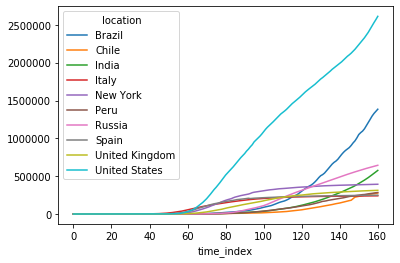

In [29]:
(eda_data[eda_data.location.isin(toptencase_locations)].set_index(['time_index', 'location'])
).total_cases.unstack().plot()

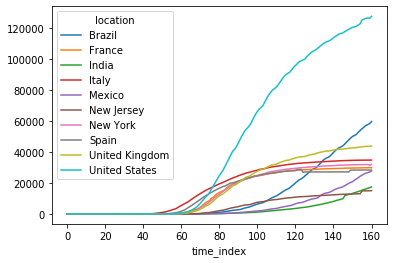

In [30]:
eda_data[eda_data.location.isin(
                                 (eda_data.set_index(['time_index', 'location']).total_deaths
                                 ).groupby(level=1).max().sort_values()[-10:].index
                               )].set_index(['time_index', 'location']).total_deaths.unstack().plot()

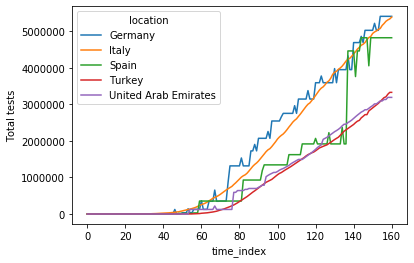

In [31]:
eda_data[eda_data.location.isin(eda_data.set_index(['time_index', 'location']).total_tests.groupby(level=1).max().sort_values()[-10:-5].index)].set_index(['time_index', 'location']).total_tests.unstack().plot()
_ = plt.ylabel('Total tests')

In [32]:
for features in ['total_tests', 'total_cases', 'total_deaths']:
    eda_data = fix_incorrect_decrease(eda_data, features, search_threshold='match')

Fixing 68 countries in the total_tests column feature
Fixing 59 countries in the total_cases column feature
Fixing 48 countries in the total_deaths column feature


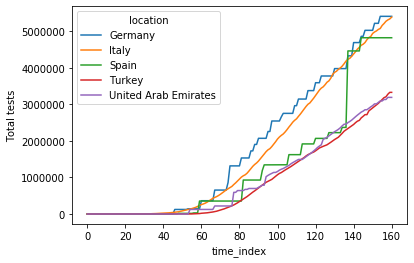

In [33]:
eda_data[eda_data.location.isin(eda_data.set_index(['time_index', 'location']).total_tests.groupby(level=1).max().sort_values()[-10:-5].index)].set_index(['time_index', 'location']).total_tests.unstack().plot()
_ = plt.ylabel('Total tests')

Label the columns with the data sources because otherwise there are repeated column names which is a pain to deal with
later on in the data exploration process.

In [34]:
for country_indices in country_groupby(eda_data):
    eda_data.loc[country_indices, column_search(eda_data,'population')] = \
    eda_data.loc[country_indices,  column_search(eda_data,'population')].fillna(method='ffill').fillna(method='bfill').values 

This is a work around for the fact that both jhucsse datasets have a column labeled "deaths", and so unless I make the distinction between jhucsse_global and jhucsse_usa this will cause issues. This distinction causes issues as well and so I find it easier to just drop it.

In [35]:
death_copy = eda_data.iloc[:,3].copy()
eda_data = eda_data.drop(columns=['deaths_jhucsse'])
eda_data = pd.concat((eda_data.iloc[:,:3], death_copy,eda_data.iloc[:,4:]),axis=1)

Calculate moving averages here to save space in exploration notebook. These features are indeed used in the regression modeling process but they are also nice to have for time-series plotting purposes as we can use the rolling means and standard deviations to give some sense of the volatility and average values (which smooths out differences in reporting/seasonality).

In [36]:
# use multiples of 7 to capture weekly seasonality
roll_widths = [3, 7, 14]

new_features = rolling_features(eda_data, 
                                  eda_data.select_dtypes(include='number').columns, 
                                  roll_widths=roll_widths)

In [37]:
export_to_modeling = pd.concat((eda_data,
                                new_features.reset_index(drop=True)
                               ),axis=1)

To avoid mixing data types upon export / import in other notebooks, replace the ```NaN``` values in object columns with the
string ```'Missing'```

In [38]:
export_to_modeling.loc[:, export_to_modeling.select_dtypes(include='object').columns] = \
export_to_modeling.loc[:, export_to_modeling.select_dtypes(include='object').columns].fillna('Missing')

The last step before I export the data is to create my own features which represent the number of "new" daily values for cases, tests, etc. The reason for this is to check and ensure that these values are consistent with the other, total values reported as well as demonstrate the differences with the "repair" of the cumulative variables performed previously. 

In [39]:
tmp = eda_data.loc[:, column_search(eda_data, 'total').tolist()+['location']].groupby('location').diff(1).fillna(0)
tmp.columns = 'new_' + tmp.columns
tmp.sample(5)

,new_total_cases_owid,new_total_deaths_owid,new_total_cases_per_million_owid,new_total_deaths_per_million_owid,new_total_tests_owid,new_total_tests_per_thousand_owid,new_total_deaths,new_total_cases,new_total_tests
23467,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0
33851,0.0,0.0,0.000,0.000,0.0,0.0,0.0,851.0,16260.0
41069,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0
5119,26417.0,1156.0,124.280,5.438,0.0,0.0,1124.0,26672.5,0.0
39329,76.0,0.0,7.525,0.000,0.0,0.0,0.0,68.0,0.0


In [40]:
tmp_per_mill = tmp / np.tile((eda_data.population_owid.values.reshape(-1,1)/1000000.),(1,9))
tmp_per_mill.columns += '_per_million'

Concatenate these new features and then export the dataset for later use in exploration notebook.

In [41]:
eda_final = pd.concat((export_to_modeling, tmp, tmp_per_mill),axis=1)

Commented out to "freeze" the saved data

In [42]:
eda_final.to_csv('data.csv')

The process above is repeated for the data which will be used in the CNN and regression models,
respectively. This is done separately to avoid mistakes and other unwarranted manipulations. This is almost certainly redundant with respect to the process above but it is to ensure that there is absolutely no room for mixups

In [43]:
names = ['jhucsse', 'testtracker',  'oxcgrt', 'owid']
export_list = []

export_list_tmp, dates_intersection, country_intersection = regularize_time_series(global_data, 
                                                                                   location_operation='intersection',
                                                                                  date_operation='intersection')
for i, x in enumerate(export_list_tmp):
    gd_export_copy = x.copy()
    gd_export_copy.columns += '_' + names[i]
    export_list.append(gd_export_copy)
    
data = add_time_indices(multiindex_to_table(pd.concat(export_list, axis=1)), index_column='cases_jhucsse')

# Want the data separated by country, the diamond princess does not have the vast majority of feature data.
data = data[~data.location.isin(['Diamond Princess','World'])]
print('The range of all dates is from {} to {}'.format(dates_intersection.min(), dates_intersection.max()))
print('The final number of locations included is {}'.format(len(country_intersection)))

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-30 00:00:00
The final number of locations included is 149


The "main" DataFrame to be exported does not distinguish between the different data sets.

In [44]:
dataframe_list, modeling_dates, modeling_countries = regularize_time_series(global_data, location_operation='intersection',
                                                                                  date_operation='intersection')
print('The range of all dates is from {} to {}'.format(modeling_dates.min(), modeling_dates.max()))
print('The number of countries included is {}'.format(len(modeling_countries)))
# Convert the multiindex DataFrame to a simple table, and then add numerical features which track the
# date and # of days since first case. 
df = add_time_indices(multiindex_to_table(pd.concat(dataframe_list, axis=1)), index_column='cases')
# keep the OWID per million features separately. 
saved_per_million = df.loc[:, column_search(df, 'per_million')].copy()
df = df.drop(columns=column_search(df, 'per_million'))

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-30 00:00:00
The number of countries included is 149


Create an index/list of the features which *should* be cumulative. Then fix their values using
forward filling / zero filling.

In [45]:
cumulative_columns = pd.Index(column_search(df, 'cases').unique().tolist()
                      +column_search(df, 'deaths').unique().tolist()
                      +column_search(df, 'tests').unique().tolist()+['recovered'])
cumulative_columns = cumulative_columns[~cumulative_columns.str.contains('new')].drop('tests_units')

The number of incorrectly decreasing values.

In [46]:
(df.set_index([df.time_index, df.location]).loc[:, cumulative_columns
                                              ].groupby(level=1).diff(1).fillna(0) < 0).sum()#.drop_duplicates()

cases                       31
cases                       31
cases_per100k               25
confirmed_cases             14
total_cases                 14
deaths                      26
deaths                      25
deaths_per100k              13
confirmed_deaths             2
total_deaths                 2
tests_cumulative            16
tests_per100k               16
total_tests                  5
total_tests_per_thousand     5
recovered                   48
dtype: int64

An example of three countries' time series for the total cases (which should be cumulative).

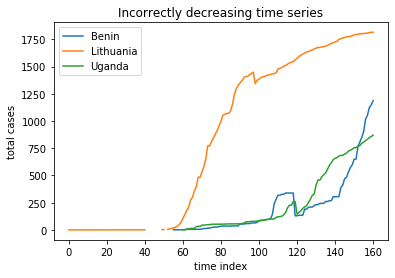

In [47]:
fig, ax = plt.subplots()
_ = ax.plot(df[df.location == 'Benin'].total_cases.values, label='Benin')
_ = ax.plot(df[df.location == 'Lithuania'].total_cases.values, label='Lithuania')
_ = ax.plot(df[df.location == 'Uganda'].total_cases.values, label='Uganda')
_ = ax.set_ylabel('total cases')
_ = ax.set_xlabel('time index')
_ = ax.set_title('Incorrectly decreasing time series')
_ = plt.legend()

Usage of custom function to fill in missing values, as well as check the validity of the time series. Mainly,
this means making sure that non-decreasing quantities in fact behave this way. It checks the difference between values $n$ and
$n+1$. If negative, the value at $n+1$ is replaced with the previous day's value. If this creates a new discrepancy, (i.e. $n+2$ is smaller then $n+1$ post-update, then it will be handled upon the next scan). Tried to make it as simple as possible to avoid any strange interactions; technically, the approximate slopes are calculated all at once and the values are updated all at once; instead of starting from the beginning and sweeping all the way through the time series. This approximation always propagates forwards, and by virtue of its calculation, always takes the larger value to be the truth. 

In [48]:
for features in cumulative_columns:
    df = fix_incorrect_decrease(df, features, search_threshold='match')

Fixing 20 countries in the cases column feature
Fixing 16 countries in the cases_per100k column feature
Fixing 10 countries in the confirmed_cases column feature
Fixing 10 countries in the total_cases column feature
Fixing 19 countries in the deaths column feature
Fixing 11 countries in the deaths_per100k column feature
Fixing 2 countries in the confirmed_deaths column feature
Fixing 2 countries in the total_deaths column feature
Fixing 13 countries in the tests_cumulative column feature
Fixing 13 countries in the tests_per100k column feature
Fixing 2 countries in the total_tests column feature
Fixing 2 countries in the total_tests_per_thousand column feature
Fixing 38 countries in the recovered column feature


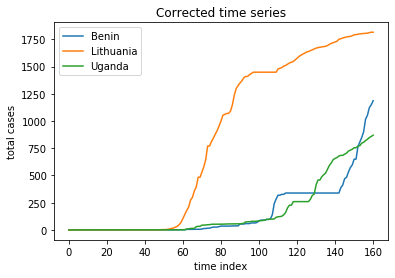

In [49]:
fig, ax = plt.subplots()
_ = ax.plot(df[df.location == 'Benin'].total_cases.values, label='Benin')
_ = ax.plot(df[df.location == 'Lithuania'].total_cases.values, label='Lithuania')
_ = ax.plot(df[df.location == 'Uganda'].total_cases.values, label='Uganda')
_ = ax.set_ylabel('total cases')
_ = ax.set_xlabel('time index')
_ = ax.set_title('Corrected time series')
_ = plt.legend()

## Preprocessing: missing values, feature production, etc.
<a id='missingval'></a>
[Return to table of contents](#toc)

The next section is concerned with the handling and imputation of missing values. The key consideration is
to not contaminate the time series with information from the future. Because I am filling in the missing values here,
I will be flagging the original missing values and keeping these flags as new features. 

My original idea was to normalize using the population of each country but I'm unsure as to whether this is the best
idea; at least without another consideration. Using the population blindly results in micro-states and small countries
being weighted heavily. Now, either I can drop these countries or I can weight the features differently; with the population *density*. This accounts for population as well as how large the state is.

## Feature production, deciding on which features to use for modeling<a id='newfeatures'></a>

In [50]:
# redundant features; some features contain the same substring but are not redundant, hence the use of .difference()
redundant_death_columns = column_search(df, 'death').difference(['cvd_death_rate'])
redundant_test_columns = column_search(df, 'test').difference(['tests_units','h2_testing_policy'])
redundant_case_columns= column_search(df, 'cases')

For whatever reason, there is a single country which is missing population information.

In [51]:
df.population_density.nunique(), df.location.nunique()

(148, 149)

Originally I pruned the lowest 10% population countries, because the countries with very small populations are 
quite pathological for the new_cases_per_million feature (i.e. the vatican has the highest values.)
I've changed my mind regarding how this should be handled and have decided to only take countries with populations
greater than one million, such that the per capita division doesn't actually result in multiplication.

In [52]:
# To prevent the SettingCopyWithSlice warning use loc, which needs index values, hence
# the application of this workaround function. 
data.loc[country_search(df, 'South Sudan'), 'population_density'] = 20.3
df.loc[country_search(df, 'South Sudan'), 'population_density'] = 20.3

df.loc[country_search(df, 'Guinea Bissau'), 'population_density'] = \
df.loc[country_search(df, 'Guinea Bissau'), 'population_density'].max()


for country_indices in country_groupby(df):
    df.loc[country_indices, ['population','population_density']] = \
    df.loc[country_indices,  ['population','population_density']].fillna(method='ffill').fillna(method='bfill').values 

df = df[df.population > 1000000.]
# these two countries have pathological new_cases_per_million time series. just get rid of them for simplicity
df = df[~df.location.isin(['Chile', 'Ecuador'])]
data = data[data.location.isin(df.location.unique())]
per_million_population = df.population / 1000000.
population_density = df.population_density
world_pop = df[df.time_index==df.time_index.max()].population.sum()
percent_pop = df.population / world_pop
data.loc[:, 'per_million_population'] = per_million_population.values

I will use/predict the new cases/deaths/etc. per day as opposed to the total. This avoids complications due to the cumulative
nature of the totals. For deciding which data source to actually use refer to the data exploration notebook.

In [53]:
data.loc[data.new_cases_per_million_owid<0, 'new_cases_per_million_owid'] = 0
data.loc[data.new_tests_owid<0, 'new_tests_owid'] = 0
data.loc[data.new_deaths_per_million_owid<0, 'new_deaths_per_million_owid'] = 0
data.loc[data.recovered_jhucsse<0, 'recovered'] = 0

# Already have a good "new tests" feature, so do not need to compute differences
df.loc[:, 'new_tests_per_million'] = (data.loc[df.index,'new_tests_testtracker'].fillna(0)/per_million_population).values
data.loc[:, 'new_tests_per_million'] = (data.loc[df.index,'new_tests_testtracker'].fillna(0)/per_million_population).values

# Already have a good "new cases" feature, so do not need to compute differences
df.loc[:, 'new_cases_per_million'] =  data.loc[df.index,'new_cases_per_million_owid'].fillna(0).values
data.loc[:, 'new_cases_per_million'] = data.loc[df.index,'new_cases_per_million_owid'].fillna(0).values

df.loc[:, 'new_deaths_per_million']  =  data.loc[df.index,'new_deaths_per_million_owid'].fillna(0).values
data.loc[:, 'new_deaths_per_million'] = data.loc[df.index,'new_deaths_per_million_owid'].fillna(0).values 

# df = fix_incorrect_decrease(df, 'recovered')
df.loc[:, 'new_recovered_per_million'] = (df.set_index(['time_index','location']).recovered.groupby(
                                            level=1).diff(1).fillna(0).values / per_million_population.values)
data.loc[:, 'new_recovered_per_million'] = (data.set_index(['time_index','location']).recovered_jhucsse.groupby(
                                            level=1).diff(1).fillna(0).values / per_million_population.values)

df.loc[:, 'log_new_recovered_per_million'] = df.loc[:, 'new_recovered_per_million'].apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_deaths_per_million']  =  df.loc[:, 'new_deaths_per_million'].apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_cases_per_million'] =  df.loc[:, 'new_cases_per_million'].apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_tests_per_million'] = df.loc[:, 'new_tests_per_million'].apply(lambda x: np.log(x+1))

Also, the time-series of countries which have caught more cases overall will likely have better reporting practices and
be closer to the actual behavior of the virus transmission. Visual inspection of certain time series leads me to believe
they will simply act as noise, obfuscating the average or "actual" behavior. 

The data has been wrangled and manipulated to best better for the modeling process, now I work towards removing redundant information and keeping only the data which seems useful.

In [54]:
# this is required from the step dropping the least populated countries, but it could not be done until now. 
df = df.reset_index(drop=True)

In [55]:
df_pruned = df.drop(columns=(redundant_death_columns.tolist() 
                         + redundant_test_columns.tolist() 
                         + redundant_case_columns.tolist()+['recovered']))

stringency =  data.loc[:, 'stringency_index_oxcgrt']

df_pruned = df_pruned.drop(columns=['country_name', 'country_code',
                                                    'm1_wildcard','stringency_index_for_display',
                                                   'stringency_legacy_index', 'stringency_legacy_index_for_display',
                                                    'government_response_index_for_display',
                                                    'containment_health_index_for_display',
                                                    'economic_support_index_for_display',
                                                    'iso_code','stringency_index'])
df_pruned.loc[:, 'stringency_index'] = stringency.values

Enumerate all feature names so that I can reorder the columns based on personal preference and modeling reasons.

In [56]:
indexers = ['location','date','time_index','days_since_first_case']
new_per_million_quantity_features = ['new_cases_per_million',
            'new_tests_per_million', 
            'new_recovered_per_million', 
            'new_deaths_per_million']
log_new_per_million_quantity_features = ['log_new_cases_per_million',
            'log_new_tests_per_million', 
            'log_new_recovered_per_million', 
            'log_new_deaths_per_million']
flag_features = column_search(df_pruned,'flag')
time_independent_features =df_pruned.loc[:, 'population':'hospital_beds_per_thousand'].columns.tolist()
time_dependent_features = df_pruned.loc[:, 'c1_school_closing':'economic_support_index'].columns.difference(flag_features).tolist()+['stringency_index']
# oxcgrt_index_variables = ['stringency_index']+df.loc[:,column_search(df,'index')].columns[1:].intersection(
#                    pd.Index(time_dependent_features)).tolist()
categorical_features = flag_features.tolist()+['tests_units', 'income_group', 'continent', 'region']
numerical_features =  (new_per_million_quantity_features
                       +log_new_per_million_quantity_features
                       +time_dependent_features)
new_quantity_features =  (new_per_million_quantity_features
                       +log_new_per_million_quantity_features)

df_reorder = df_pruned.loc[:, indexers
                              +numerical_features
                              +time_independent_features
                              +categorical_features]

Manipulate categorical features and fill in missing values with string ```'Missing'```

The original OxCGRT flag columnstake values 1.0, 0.0, np.nan. 
Convert these to categorical, and for the sake of column names map floats to str.
Afterwards, drop the column that corresponds to missing values to remove collinearity. 

In [57]:
categorical_df = df_reorder.loc[:, categorical_features].fillna('Missing').astype('category')
for col in categorical_df.columns:
    categorical_df.loc[:, col] = categorical_df.loc[:, col].cat.rename_categories({1.0 : '1', 0. : '0'})
    
categorical_dummies = pd.get_dummies(categorical_df)
categorical_dummies_without_collinearity = regularize_names(categorical_dummies[categorical_dummies.columns[~categorical_dummies.columns.str.contains('Missing')]])

In [58]:
df_reorder = pd.concat((df_reorder.drop(columns=categorical_features),
                        categorical_dummies_without_collinearity),axis=1)
categorical_dummy_features = categorical_dummies_without_collinearity.columns.tolist()

Deal with missing values with strategies that are dependent upon where or not the feature is time dependent or not.

In [59]:
# only create missing flag variables for features that are missing more than a minimum number of values (100)         
missing_categoricals = df_reorder.iloc[:, np.where(df_reorder.isna().sum() > 100)[0]].isna().astype(int)
missing_categoricals.columns = missing_categoricals.columns + '_missing_flag'

for country_indices in country_groupby(df_reorder):
    fill_tmp = df_reorder.loc[country_indices, time_independent_features].fillna(method='ffill').fillna(method='bfill')
    df_reorder.loc[country_indices, time_independent_features] = fill_tmp.values
    df_reorder.loc[country_indices, time_dependent_features] = df_reorder.loc[country_indices, time_dependent_features].fillna(method='ffill').fillna(value=0)
df_reorder.loc[:, time_independent_features] = df_reorder.loc[:, time_independent_features].fillna(df_reorder.loc[:, time_independent_features].median())

Compose the DataFrame with all engineered and original features.

In [60]:
location_dummies_without_collinearity = pd.get_dummies(df.location, drop_first=True)
location_dummies_without_collinearity.columns += '_location_flag'
location_dummies_without_collinearity = regularize_names(location_dummies_without_collinearity)
export_df = pd.concat((df_reorder, location_dummies_without_collinearity, missing_categoricals),axis=1)
export_df = export_df.loc[:, indexers 
                  + new_per_million_quantity_features 
                  + log_new_per_million_quantity_features
                  + time_dependent_features
                  + time_independent_features
                  + categorical_dummy_features
                  + location_dummies_without_collinearity.columns.tolist()
                  + missing_categoricals.columns.tolist()
                 ]

Because I'm going to impute values for the time independent features, it may or may not be important to track this by flagging
the missing values via one-hot encoding. Note that I have just manipulated the flagging columns so that *their* missing value flags are not included; but again this is because of linear dependency reasons. 

For time independent features, do not have to be careful with time; because there is no two-sided fillna method that
I am aware of, handle this by filling forwards and backwards.

Time dependent features can only be filled forward so that information from the future is not visible from the past. Additionally, any other missing values are filled with 0's; only other options would be, for instance, the mean up to that date. 

# Feature production

Create the moving averages of the time dependent features to attempt to convey the time dependence to the regression models. 

Previously, I used rolling window widths of 7,14,21,28 days but upon inspection the 21 and 28 day MA simply introduced a number of nearly collinear features, which in turn affects the ridge regression. Therefore, these have been discarded

In [61]:
roll_widths = [3, 7, 14]

lean_features_list =  indexers+new_per_million_quantity_features#+time_dependent_features
numerical_features = new_per_million_quantity_features#+time_dependent_features
regression_df_lean = modify_time_series_zeros(export_df.loc[:,lean_features_list].copy(), 
                                                        new_per_million_quantity_features)

The dataframe being exported next is a subset of all  features prepared for the regression process. 

In [62]:
new_features = rolling_means(regression_df_lean.copy(), new_per_million_quantity_features,
                                     roll_widths=roll_widths)

regression_df_lean = pd.concat((regression_df_lean,
                                new_features,
                               ),axis=1)
#Comment out to "freeze" the saved data
regression_df_lean.fillna(0).to_csv('regression_data.csv')

In [63]:
regression_df_lean.head()

,location,date,time_index,days_since_first_case,new_cases_per_million,new_tests_per_million,new_recovered_per_million,new_deaths_per_million,new_cases_per_million_rolling_mean_3,new_tests_per_million_rolling_mean_3,new_recovered_per_million_rolling_mean_3,new_deaths_per_million_rolling_mean_3,new_cases_per_million_rolling_mean_7,new_tests_per_million_rolling_mean_7,new_recovered_per_million_rolling_mean_7,new_deaths_per_million_rolling_mean_7,new_cases_per_million_rolling_mean_14,new_tests_per_million_rolling_mean_14,new_recovered_per_million_rolling_mean_14,new_deaths_per_million_rolling_mean_14
0,Afghanistan,2020-01-22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,2020-01-23,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,2020-01-24,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,2020-01-25,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,2020-01-26,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataframe being exported next contains all features prepared for the regression process. 

In [64]:
# use multiples of 7 to capture weekly seasonality
# roll_widths = [3, 7, 14, 21, 28]
roll_widths = [3, 7, 14]

numerical_features =  (new_per_million_quantity_features
                       +log_new_per_million_quantity_features
                       +time_dependent_features)

new_quantity_features = (new_per_million_quantity_features
                       +log_new_per_million_quantity_features)

df_modified = modify_time_series_zeros(export_df, new_quantity_features)
export_df.loc[:, new_quantity_features] = df_modified.loc[:, new_quantity_features].values

In [65]:
new_features = rolling_features(export_df, 
                                  new_quantity_features, 
                                  roll_widths=roll_widths)

In [66]:
regression_df = pd.concat((export_df,
                                new_features.reset_index(drop=True)
                               ),axis=1)

Commented out to "freeze" the saved data

In [67]:
regression_df.fillna(0).to_csv('regression_data_full.csv')

For the CNN, stick to the most important time-series features only.

In [68]:
cnn_features =  (indexers 
                  + new_per_million_quantity_features
                  + log_new_per_million_quantity_features
                  + time_dependent_features
                )

cnn_df = export_df.loc[:, cnn_features]
cnn_df.to_csv('cnn_data_vanilla.csv')
# changing the values to better respect 

cnn_modified = modify_time_series_zeros(cnn_df, (new_per_million_quantity_features 
                                                 +log_new_per_million_quantity_features
                                                 +time_dependent_features))

Commented out to "freeze" the saved data

In [69]:
cnn_modified.fillna(0).to_csv('cnn_data.csv')

The one-hot encoded columns and even the government response time series may introduce noise due to their
piecewise-constant nature of their values. Just in-case, create a version of the regression data without these
features.